In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


data = pd.read_csv("FINCORP.csv")

data.columns = data.columns.str.strip()


data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")


tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["Complaint/ Opinion"])
X = tokenizer.texts_to_sequences(data["Complaint/ Opinion"])
X = pad_sequences(X)

label_encoder = LabelEncoder()


data.columns = data.columns.str.strip()


print(data.columns)


y = label_encoder.fit_transform(data["Intent"])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Index(['Domain', 'Complaint/ Opinion', 'Complaint Label', 'Severity level',
       'Sentiment', 'Emotion', 'Intent', 'Unnamed: 7', 'Unnamed: 8', '2',
       'Unnamed: 10'],
      dtype='object')


In [4]:
import pandas as pd

def get_unique_elements_with_counts(csv_file, columns):
   
    df = pd.read_csv(csv_file)

    
    unique_elements_with_counts = {}
    for column in columns:
        unique_elements_with_counts[column] = df[column].value_counts().reset_index().rename(columns={column: 'count', 'index': column})

    return unique_elements_with_counts
csv_file_path = 'synthe.csv'
columns_to_check = ['Intent']  
result = get_unique_elements_with_counts(csv_file_path, columns_to_check)


for column, df in result.items():
    print(f"Unique elements in {column} with counts:")
    print(df)
    print()


Unique elements in Intent with counts:
                 count  count
0           Assistance    394
1             Feedback    235
2                Query    171
3              General    131
4           Suggestion     87
5     Feedback/General      2
6  Feedback/Sugeestion      1



In [48]:
import pandas as pd

def get_unique_elements_with_counts(csv_file, columns):
    df = pd.read_csv(csv_file)
    unique_elements_with_counts = {}
    for column in columns:
        unique_elements_with_counts[column] = df[column].value_counts().reset_index().rename(columns={column: 'count', 'index': column})

    return unique_elements_with_counts

csv_file_path = 'shuffled_data.csv'
columns_to_check = ['Intent']  
result = get_unique_elements_with_counts(csv_file_path, columns_to_check)
for column, df in result.items():
    print(f"Unique elements in {column} with counts:")
    print(df)
    print()


Unique elements in Intent with counts:
        count  count
0    Feedback   1000
1  Assistance   1000
2     General   1000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

from tqdm import tqdm
import re
from nltk.corpus import stopwords
nltk.download('stopwords')



In [67]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")


In [69]:
!pip install transformers torch pandas scikit-learn nltk tqdm


In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.nn import CrossEntropyLoss
from transformers import get_cosine_schedule_with_warmup

from tqdm import tqdm
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

back_translation_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
back_translation_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")

def back_translate_augment(text):
    
    input_ids = back_translation_tokenizer.encode(text, return_tensors="pt", max_length=128, truncation=True)

    
    with torch.no_grad():
        translated_ids = back_translation_model.generate(input_ids)
    
    
    translated_text = back_translation_tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    
    return translated_text


data_path = "shuffled_data.csv"


data = pd.read_csv(data_path)


data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")
data = data.dropna(subset=["Intent"])


data["Complaint/ Opinion"] = data["Complaint/ Opinion"].apply(back_translate_augment)


def preprocess_text(text):
    
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    processed_text = ' '.join(tokens)

    return processed_text

data["Complaint/ Opinion"] = data["Complaint/ Opinion"].apply(preprocess_text)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
encoded_data = tokenizer.batch_encode_plus(
    data["Complaint/ Opinion"].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=128,
    truncation=True,
    return_tensors="pt",
)


label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data["Intent"])
labels = torch.tensor(labels)


input_ids = encoded_data["input_ids"]
attention_mask = encoded_data["attention_mask"]
X_train, X_test, y_train, y_test = train_test_split(
    range(len(input_ids)), labels, test_size=0.2, random_state=42
)


train_dataset = TensorDataset(input_ids[X_train], attention_mask[X_train], y_train)
test_dataset = TensorDataset(input_ids[X_test], attention_mask[X_test], y_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_), output_hidden_states=False)
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=num_training_steps)

intent_class_counts = data.groupby("Intent")["Complaint/ Opinion"].value_counts().unstack()
class_weights = 1.0 / intent_class_counts.sum(axis=1)
class_weights = torch.tensor(class_weights)
criterion = CrossEntropyLoss(weight=class_weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10  
early_stopping_counter = 0
best_validation_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {average_loss}")

    scheduler.step()

    # Validation
    model.eval()
    total_validation_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Validation"):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_validation_loss += loss.item()

    average_validation_loss = total_validation_loss / len(test_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Validation Loss: {average_validation_loss}")

    # Early stopping
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 3:
            print("Early stopping! No improvement in validation loss.")
            break
model.eval()
all_predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, all_predictions)
print(f"Test Accuracy: {accuracy}")


[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>
[nltk_data] Error loading punkt: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
/Users/siddharthparasher/anaconda3/lib/python3.11/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


/Users/siddharthparasher/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


TypeError: batch_text_or_text_pairs has to be a list or a tuple (got <class 'numpy.ndarray'>)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset
data = pd.read_csv("FINCORP_last.csv")

# Handle missing values
#data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")
#data = data.dropna(subset=["Intent"])

# Text preprocessing function
def preprocess_text(text):
    # Handle the case when the input is not a string (NaN or other)
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and extra whitespaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply text preprocessing to "Complaint/ Opinion" attribute
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].apply(preprocess_text)

# Tokenize the input text
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
encoded_data = tokenizer.batch_encode_plus(
    data["Complaint/ Opinion"].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=128,
    truncation=True,
    return_tensors="pt",
)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data["Intent "])

labels = torch.tensor(labels)

# Split the data
input_ids = encoded_data["input_ids"]
attention_mask = encoded_data["attention_mask"]
X_train, X_test, y_train, y_test = train_test_split(
    range(len(input_ids)), labels, test_size=0.2, random_state=42
)

# Create DataLoader
train_dataset = TensorDataset(input_ids[X_train], attention_mask[X_train], y_train)
test_dataset = TensorDataset(input_ids[X_test], attention_mask[X_test], y_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize RoBERTa model with dropout
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_))
model.dropout = torch.nn.Dropout(0.2)  # Increased dropout

# Set up optimizer and scheduler with adjusted learning rate
optimizer = AdamW(model.parameters(), lr=5e-6)  # Adjusted learning rate
scheduler = StepLR(optimizer, step_size=2, gamma=0.9)  # Learning rate scheduler

# Define loss function with adjusted class weights
class_weights = 1.0 / torch.bincount(labels)
criterion = CrossEntropyLoss(weight=class_weights)

# Training loop with early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10  # Increased number of epochs
early_stopping_counter = 0
best_validation_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {average_loss}")

    scheduler.step()

    # Validation
    model.eval()
    total_validation_loss = 0
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Validation"):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_validation_loss += loss.item()

    average_validation_loss = total_validation_loss / len(test_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Validation Loss: {average_validation_loss}")

    # Early stopping
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 3:
            print("Early stopping! No improvement in validation loss.")
            break

# Evaluation
model.eval()
all_predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, all_predictions)
print(f"Test Accuracy: {accuracy}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(true_labels, all_predictions, target_names=label_encoder.classes_))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddharthparasher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/siddharthparasher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/siddharthparasher/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_he

Epoch 1/10, Average Training Loss: 1.6407473480245869


Validation: 100%|█████████████████████████████| 158/158 [00:42<00:00,  3.70it/s]


Epoch 1/10, Average Validation Loss: 1.57763932324663


Epoch 2/10: 100%|█████████████████████████████| 628/628 [13:50<00:00,  1.32s/it]


Epoch 2/10, Average Training Loss: 1.5581934850686674


Validation: 100%|█████████████████████████████| 158/158 [00:40<00:00,  3.87it/s]


Epoch 2/10, Average Validation Loss: 1.612440279012994


Epoch 3/10: 100%|█████████████████████████████| 628/628 [12:02<00:00,  1.15s/it]


Epoch 3/10, Average Training Loss: 1.5236258204955204


Validation: 100%|█████████████████████████████| 158/158 [00:39<00:00,  3.99it/s]


Epoch 3/10, Average Validation Loss: 1.5795849222171157


Epoch 4/10: 100%|███████████████████████████| 628/628 [3:03:16<00:00, 17.51s/it]


Epoch 4/10, Average Training Loss: 1.4755914628885354


Validation: 100%|███████████████████████████| 158/158 [2:02:20<00:00, 46.46s/it]


Epoch 4/10, Average Validation Loss: 1.6224808730656588
Early stopping! No improvement in validation loss.


Evaluating: 100%|█████████████████████████████| 158/158 [08:45<00:00,  3.32s/it]


Test Accuracy: 0.2967382657120127
Classification Report:


ValueError: Number of classes, 5, does not match size of target_names, 8. Try specifying the labels parameter

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load the data
data = pd.read_csv("filtered_data.csv")

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Handle missing values
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["Complaint/ Opinion"])
X = tokenizer.texts_to_sequences(data["Complaint/ Opinion"])
X = pad_sequences(X, padding='post')  # Add padding to sequences

label_encoder = LabelEncoder()

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Confirm the column names
print(data.columns)

# Use the correct column name for the target variable
y = label_encoder.fit_transform(data["Intent"])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model...
embedding_dim = 100  # Adjust as needed
lstm_units = 150  # Adjust as needed
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=X.shape[1]))
model.add(LSTM(lstm_units))
model.add(Dense(units=len(set(y)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


Index(['Domain', 'Complaint/ Opinion', 'Complaint Label', 'Severity level',
       'Sentiment', 'Emotion', 'Intent', 'Unnamed: 7', 'Unnamed: 8', '2',
       'Unnamed: 10'],
      dtype='object')
Epoch 1/10
98/98 [==============================] - 6s 52ms/step - loss: 1.0704 - accuracy: 0.3864 - val_loss: 1.0734 - val_accuracy: 0.4036
Epoch 2/10
98/98 [==============================] - 5s 53ms/step - loss: 1.0665 - accuracy: 0.3960 - val_loss: 1.0793 - val_accuracy: 0.3921
Epoch 3/10
77/98 [======================>.......] - ETA: 1s - loss: 1.0571 - accuracy: 0.4294

KeyboardInterrupt: 

In [54]:
import pandas as pd

# Load the data
#data = pd.read_csv("FINCORP.csv")

# Mapping function
def map_intent_emotion_to_priority(intent, emotion):
    if intent in ["Assistance"] and emotion in ["anger", "fear","disgust","surprise"]:
        return "very high"
    elif intent in ["Query"] and emotion in ["anger", "fear", "sadness", "other","happiness","surprise"]:
        return "high"
    elif intent in ["general"] and emotion in ["anger", "fear"]:
        return "mild"
    elif intent in ["Assistance"] and emotion in ["sadness"]:
        return "mild"
    elif intent in ["suggestion", "Feedback","Feedback/Sugeestion","Query"] and emotion in ["anger", "fear", "sadness", "other","happiness","surprise"]:
        return "mild"
    elif intent in ["General","Feedback/General"] and emotion in [ "sadness", "other","happiness","surprise"]:
        return "low"
    else:
        return "unknown"

# Apply mapping to create Priority column
data['Priority'] = data.apply(lambda row: map_intent_emotion_to_priority(row['Intent'], row['Emotion']), axis=1)

# Drop rows with NaN values
data = data.dropna(subset=['Intent', 'Emotion'])

# Display the updated DataFrame
print(data[['Complaint/ Opinion', 'Intent', 'Emotion', 'Priority']])


                                     Complaint/ Opinion      Intent  \
0     Can someone tell me if transaction fail betwee...  Assistance   
1     @LICIndiaForever @Paytmcare @Paytm As part of ...       Query   
2     @ICICIBank_Care This is something very serious...  Assistance   
4     Fraud transaction through CRED for SBI C-Card ...    Feedback   
5     =A8 @ICICIBank @ICICIBank_Care I already made ...     General   
...                                                 ...         ...   
3594  @CryptoClash1 @BlocVaultAPP One of your revolu...  Assistance   
3595  @pintuya14546019 Hi Pintu! We understand your ...  Assistance   
3596  1st step.\n\nalready unlinked my debit card to...  Assistance   
3597  @Dpk_is_here Hi Deepak! We understand your con...  Assistance   
3598  @jyotish04 Hi Jyotish! We understand your conc...  Assistance   

        Emotion   Priority  
0       sadness       mild  
1       sadness       high  
2         anger  very high  
4      surprise       mild  
5 

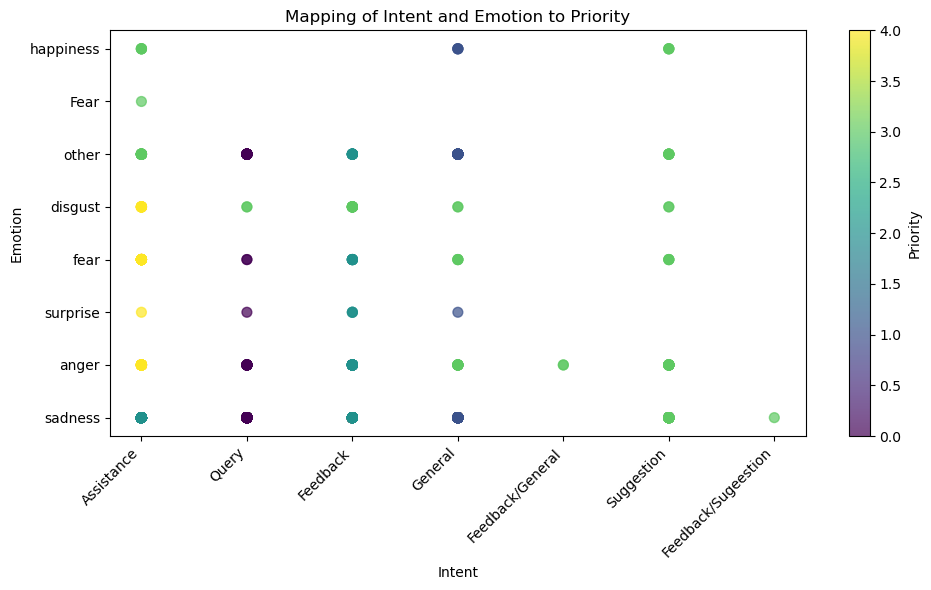

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded the data using pd.read_csv("FINCORP.csv")
# Replace the file path with the actual path to your CSV file
#data = pd.read_csv("FINCORP.csv")

# Mapping function
def map_intent_emotion_to_priority(intent, emotion):
    if intent in ["Assistance"] and emotion in ["anger", "fear", "disgust", "surprise"]:
        return "very high"
    elif intent in ["Query"] and emotion in ["anger", "fear", "sadness", "other", "happiness", "surprise"]:
        return "high"
    elif intent in ["general"] and emotion in ["anger", "fear"]:
        return "mild"
    elif intent in ["Assistance"] and emotion in ["sadness"]:
        return "mild"
    elif intent in ["suggestion", "Feedback", "Feedback/Suggestion", "Query"] and emotion in ["anger", "fear", "sadness", "other", "happiness", "surprise"]:
        return "mild"
    elif intent in ["General", "Feedback/General"] and emotion in ["sadness", "other", "happiness", "surprise"]:
        return "low"
    else:
        return "unknown"

# Apply mapping to create Priority column
data['Priority'] = data.apply(lambda row: map_intent_emotion_to_priority(row['Intent'], row['Emotion']), axis=1)

# Drop rows with NaN values
data = data.dropna(subset=['Intent', 'Emotion'])

# Plotting the mapping with rotated X-axis labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['Intent'], data['Emotion'], c=data['Priority'].astype('category').cat.codes, cmap='viridis', s=50, alpha=0.7)
plt.title('Mapping of Intent and Emotion to Priority')
plt.xlabel('Intent')
plt.ylabel('Emotion')
plt.colorbar(scatter, label='Priority')

# Rotate X-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [45]:
import pandas as pd

# Load the data
#data = pd.read_csv("FINCORP.csv")

# Get unique values in the 'Emotion' column
unique_emotions = data['Emotion'].unique()
print("Unique Emotions:", unique_emotions)

# Get unique values in the 'Intent' column
unique_intents = data['Intent'].unique()
print("Unique Intents:", unique_intents)


Unique Emotions: ['sadness' 'anger' 'surprise' 'fear' 'disgust' 'other' 'Fear' 'happiness']
Unique Intents: ['Assistance' 'Query' nan 'Feedback' 'General' 'Feedback/General'
 'Suggestion' 'Feedback/Sugeestion']


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load the data
data = pd.read_csv("tabular-actgan-65747db80bf737e9588d2b05-data_preview.csv")
# Merge "Query" and "General" into "General"
data["Intent"].replace({"Query": "General"}, inplace=True)

# Merge "Feedback" and "Suggestion" into "Feedback"
data["Intent"].replace({"Feedback": "Feedback/Suggestion"}, inplace=True)

# Remove rows with classes "General" and "Feedback/Suggestion"
data = data[~data["Intent"].isin(["Feedback/General", "Feedback/Suggestion"])]

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Handle missing values
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")
data = data.dropna(subset=['Intent', 'Emotion'])
# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["Complaint/ Opinion"])
X = tokenizer.texts_to_sequences(data["Complaint/ Opinion"])
X = pad_sequences(X, padding='post')  # Add padding to sequences

label_encoder = LabelEncoder()

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Confirm the column names
print(data.columns)

# Use the correct column name for the target variable
y = label_encoder.fit_transform(data["Intent"])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# Build the model...
embedding_dim = 100  # Adjust as needed
lstm_units = 150  # Adjust as needed
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=X.shape[1]))
model.add(LSTM(lstm_units))
model.add(Dense(units=len(set(y)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Map Intent and Emotion to Priority
def map_intent_emotion_to_priority(intent, emotion):
    if intent in ["assistance"] and emotion in ["anger", "fear"]:
        return "high"
    elif intent in ["suggestion", "feedback"] and emotion in ["anger", "fear", "sadness", "other"]:
        return "mild"
    elif intent in ["general"]:
        return "low"
    else:
        return "unknown"

# Apply mapping to create Priority column
data['Priority'] = data.apply(lambda row: map_intent_emotion_to_priority(row['Intent'], row['Emotion']), axis=1)

# Display the updated DataFrame
print(data)


Index(['Domain', 'Complaint/ Opinion', 'Complaint Label', 'Severity level',
       'Sentiment', 'Emotion', 'Intent', 'Unnamed: 7', 'Unnamed: 8', '2',
       'Unnamed: 10'],
      dtype='object')
Epoch 1/10
69/69 [==============================] - 4s 47ms/step - loss: 1.0592 - accuracy: 0.5263 - val_loss: 1.0370 - val_accuracy: 0.5667
Epoch 2/10
69/69 [==============================] - 3s 44ms/step - loss: 1.0287 - accuracy: 0.5400 - val_loss: 1.0335 - val_accuracy: 0.5667
Epoch 3/10
69/69 [==============================] - 3s 46ms/step - loss: 1.0231 - accuracy: 0.5400 - val_loss: 1.0212 - val_accuracy: 0.5667
Epoch 4/10
69/69 [==============================] - 3s 45ms/step - loss: 1.0219 - accuracy: 0.5400 - val_loss: 1.0338 - val_accuracy: 0.5667
Epoch 5/10
57/69 [=======================>......] - ETA: 0s - loss: 1.0172 - accuracy: 0.5422

KeyboardInterrupt: 

In [12]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Return preprocessed text
    return text.strip()

In [23]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Load the data
data = pd.read_csv("tabular-actgan-65747db80bf737e9588d2b05-data_preview.csv")

# Drop rows with NaN values
data = data.dropna(subset=['Intent', 'Emotion'])

# Filter for specific intent classes
valid_intent_classes = ["General", "Feedback", "Query", "Suggestion", "Assistance"]
data = data[data['Intent'].isin(valid_intent_classes)]

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Handle missing values
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")

# Preprocess the "Complaint/ Opinion" attribute
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].apply(preprocess_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data["Complaint/ Opinion"])

label_encoder = LabelEncoder()

# Convert sparse matrix to NumPy array
X_tfidf_array = X_tfidf.toarray()

# Confirm the column names
print(data.columns)

# Use the correct column name for the target variable
y = label_encoder.fit_transform(data["Intent"])

# Split the data
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_array, y, test_size=0.2, random_state=42)

# Build the model with Bidirectional LSTM
embedding_dim = 100  # Adjust as needed
lstm_units = 150  # Adjust as needed

model = Sequential()
model.add(Embedding(input_dim=X_tfidf_array.shape[1], output_dim=embedding_dim, input_length=X_tfidf_array.shape[1]))
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dense(units=len(set(y)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_tfidf, y_test)
print(f"Test Accuracy: {test_accuracy}")


Index(['Domain', 'Complaint/ Opinion', 'Complaint Label', 'Severity level',
       'Sentiment', 'Emotion', 'Intent', 'Unnamed: 7', 'Unnamed: 8', '2',
       'Unnamed: 10'],
      dtype='object')
Epoch 1/10
45/98 [============>.................] - ETA: 6:38 - loss: 1.5553 - accuracy: 0.3049

KeyboardInterrupt: 

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the data
data = pd.read_csv("tabular-actgan-65747db80bf737e9588d2b05-data_preview.csv")

# Drop rows with NaN values
data = data.dropna(subset=['Intent', 'Emotion'])

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Handle missing values
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")

# Preprocess the "Complaint/ Opinion" attribute
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].apply(preprocess_text)
print(data)
# Use TF-IDF vectorizer to convert text data to numerical features
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the max_features parameter
X = vectorizer.fit_transform(data["Complaint/ Opinion"])

label_encoder = LabelEncoder()

# Use the correct column name for the target variable
y = label_encoder.fit_transform(data["Intent"])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy}")


                   Domain                                 Complaint/ Opinion  \
0              Debit Card  hi jyotish we understand your concern you can ...   
1        Customer Service  from the suggested portal reply received conta...   
2              Netbanking        months days to loan application no response   
3              Debit Card  hi arun we understand your concern you can dep...   
4        Transaction Fail  the digital experience even for a simple trans...   
...                   ...                                                ...   
4995           Debit Card  sorry for my english but i wanna try because i...   
4996  Transaction Failure  but why the sms says its from icici has someon...   
4997     Customer Service  im unable to make any transaction using my cre...   
4998               Salary  hi jyotish we understand your concern you can ...   
4999     Transaction Fail  getting error during net banking transaction a...   

      Complaint Label        Severity l

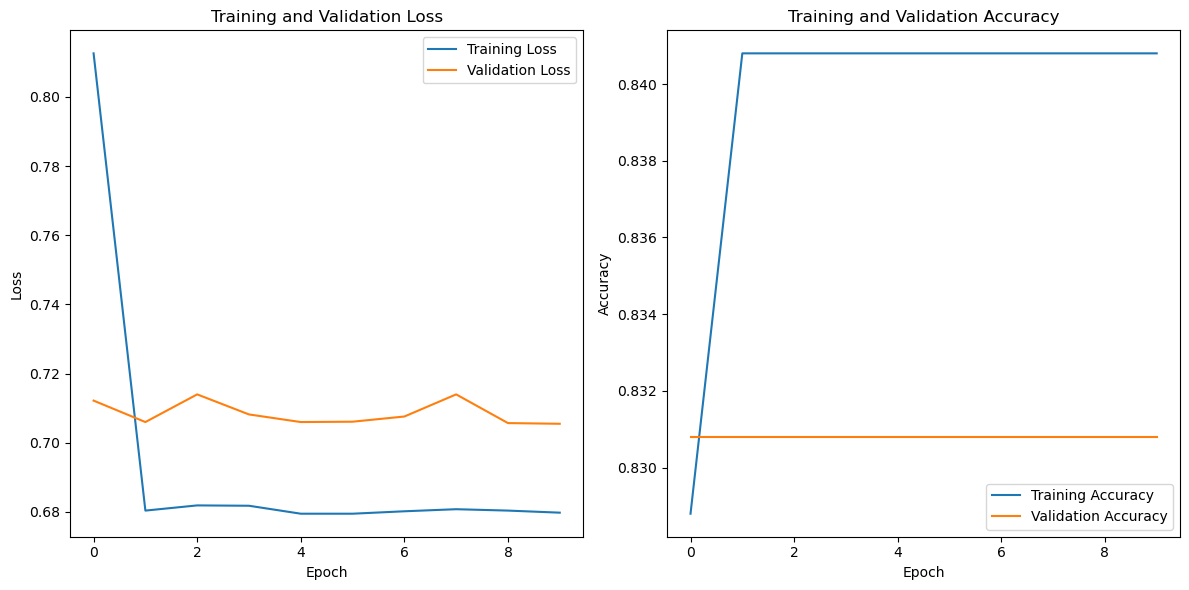

In [4]:
import matplotlib.pyplot as plt

# Your training history (replace this with your actual training history)
history = {
    'loss': [0.8126, 0.6804, 0.6819, 0.6818, 0.6795, 0.6795, 0.6802, 0.6808, 0.6804, 0.6798],
    'accuracy': [0.8288, 0.8408, 0.8408, 0.8408, 0.8408, 0.8408, 0.8408, 0.8408, 0.8408, 0.8408],
    'val_loss': [0.7122, 0.7060, 0.7140, 0.7082, 0.7060, 0.7061, 0.7076, 0.7140, 0.7057, 0.7055],
    'val_accuracy': [0.8308, 0.8308, 0.8308, 0.8308, 0.8308, 0.8308, 0.8308, 0.8308, 0.8308, 0.8308]
}

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset
data = pd.read_csv("shuffled_data.csv")

# Handle missing values
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")
data = data.dropna(subset=["Intent"])

# Text preprocessing function
def preprocess_text(text):
    # Handle the case when the input is not a string (NaN or other)
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and extra whitespaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply text preprocessing to "Complaint/ Opinion" attribute
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].apply(preprocess_text)

# Tokenize the input text
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
encoded_data = tokenizer.batch_encode_plus(
    data["Complaint/ Opinion"].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=128,
    truncation=True,
    return_tensors="pt",
)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data["Intent"])
labels = torch.tensor(labels)

# Split the data
input_ids = encoded_data["input_ids"]
attention_mask = encoded_data["attention_mask"]
X_train, X_test, y_train, y_test = train_test_split(
    range(len(input_ids)), labels, test_size=0.2, random_state=42
)

# Create DataLoader
train_dataset = TensorDataset(input_ids[X_train], attention_mask[X_train], y_train)
test_dataset = TensorDataset(input_ids[X_test], attention_mask[X_test], y_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize RoBERTa model with dropout
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_))
model.dropout = torch.nn.Dropout(0.2)  # Increased dropout

# Set up optimizer and scheduler with adjusted learning rate
optimizer = AdamW(model.parameters(), lr=5e-6)  # Adjusted learning rate
scheduler = StepLR(optimizer, step_size=2, gamma=0.9)  # Learning rate scheduler

# Define loss function with adjusted class weights
class_weights = 1.0 / torch.bincount(labels)
criterion = CrossEntropyLoss(weight=class_weights)

# Training loop with early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10  # Increased number of epochs
early_stopping_counter = 0
best_validation_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {average_loss}")

    scheduler.step()

    # Validation
    model.eval()
    total_validation_loss = 0
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Validation"):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_validation_loss += loss.item()

    average_validation_loss = total_validation_loss / len(test_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Validation Loss: {average_validation_loss}")

    # Early stopping
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 3:
            print("Early stopping! No improvement in validation loss.")
            break

# Evaluation
model.eval()
all_predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, all_predictions)
print(f"Test Accuracy: {accuracy}")


[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>
[nltk_data] Error loading punkt: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
/Users/siddharthparasher/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.laye

Epoch 1/10, Average Training Loss: 1.1007412906487783


Validation: 100%|███████████████████████████████| 75/75 [00:18<00:00,  4.05it/s]


Epoch 1/10, Average Validation Loss: 1.103010261853536


Epoch 2/10: 100%|█████████████████████████████| 300/300 [04:56<00:00,  1.01it/s]


Epoch 2/10, Average Training Loss: 1.0986580276489257


Validation: 100%|███████████████████████████████| 75/75 [00:16<00:00,  4.41it/s]


Epoch 2/10, Average Validation Loss: 1.1000519212086994


Epoch 3/10: 100%|█████████████████████████████| 300/300 [04:57<00:00,  1.01it/s]


Epoch 3/10, Average Training Loss: 1.096458848118782


Validation: 100%|███████████████████████████████| 75/75 [00:18<00:00,  3.97it/s]


Epoch 3/10, Average Validation Loss: 1.102331142425537


Epoch 4/10: 100%|█████████████████████████████| 300/300 [04:56<00:00,  1.01it/s]


Epoch 4/10, Average Training Loss: 1.0925002437829971


Validation: 100%|███████████████████████████████| 75/75 [00:17<00:00,  4.39it/s]


Epoch 4/10, Average Validation Loss: 1.1036490058898927


Epoch 5/10: 100%|█████████████████████████████| 300/300 [04:58<00:00,  1.00it/s]


Epoch 5/10, Average Training Loss: 1.0879595319430033


Validation: 100%|███████████████████████████████| 75/75 [00:18<00:00,  4.10it/s]


Epoch 5/10, Average Validation Loss: 1.1109206088383992
Early stopping! No improvement in validation loss.


Evaluating: 100%|███████████████████████████████| 75/75 [00:18<00:00,  3.96it/s]

Test Accuracy: 0.31833333333333336


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Load your dataset
data = pd.read_csv("shuffled_data.csv")

# Handle missing values
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")
data = data.dropna(subset=["Intent"])

# Tokenize the input text
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
encoded_data = tokenizer.batch_encode_plus(
    data["Complaint/ Opinion"].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=128,
    truncation=True,
    return_tensors="pt",
)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data["Intent"])
labels = torch.tensor(labels)

# Split the data
input_ids = encoded_data["input_ids"]
attention_mask = encoded_data["attention_mask"]
X_train, X_test, y_train, y_test = train_test_split(
    range(len(input_ids)), labels, test_size=0.2, random_state=42
)

# Create DataLoader
train_dataset = TensorDataset(input_ids[X_train], attention_mask[X_train], y_train)
test_dataset = TensorDataset(input_ids[X_test], attention_mask[X_test], y_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize RoBERTa model with dropout
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_))
model.dropout = torch.nn.Dropout(0.2)  # Increased dropout

# Set up optimizer and scheduler with adjusted learning rate
optimizer = AdamW(model.parameters(), lr=5e-6)  # Adjusted learning rate
scheduler = StepLR(optimizer, step_size=2, gamma=0.9)  # Learning rate scheduler

# Define loss function with adjusted class weights
class_weights = 1.0 / torch.bincount(labels)
criterion = CrossEntropyLoss(weight=class_weights)

# Training loop with early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10  # Increased number of epochs
early_stopping_counter = 0
best_validation_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {average_loss}")

    scheduler.step()

    # Validation
    model.eval()
    total_validation_loss = 0
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Validation"):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_validation_loss += loss.item()

    average_validation_loss = total_validation_loss / len(test_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Validation Loss: {average_validation_loss}")

    # Early stopping
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 3:
            print("Early stopping! No improvement in validation loss.")
            break

# Evaluation
model.eval()
all_predictions = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, all_predictions)
print(f"Test Accuracy: {accuracy}")


/Users/siddharthparasher/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on anothe

Epoch 1/10, Average Training Loss: 1.0319575681686401


Validation: 100%|█████████████████████████████| 125/125 [00:28<00:00,  4.44it/s]


Epoch 1/10, Average Validation Loss: 1.0310066957473756


Epoch 2/10: 100%|█████████████████████████████| 500/500 [16:48<00:00,  2.02s/it]


Epoch 2/10, Average Training Loss: 1.0096377865076065


Validation: 100%|█████████████████████████████| 125/125 [00:27<00:00,  4.49it/s]


Epoch 2/10, Average Validation Loss: 1.013351683616638


Epoch 3/10:  44%|████████████▋                | 219/500 [39:38<50:51, 10.86s/it]


KeyboardInterrupt: 

In [33]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("tabular-actgan-65747db80bf737e9588d2b05-data_preview.csv")

# Merge "Query" and "General" into "General"
data["Intent"].replace({"Query": "General"}, inplace=True)

# Merge "Feedback" and "Suggestion" into "Feedback"
data["Intent"].replace({"Suggestion": "Feedback"}, inplace=True)

# Remove rows with classes "General" and "Feedback/Suggestion"
data = data[~data["Intent"].isin(["Feedback/General", "Feedback/Suggestion"])]

# Save the manipulated data to a new CSV file
data.to_csv("manipulated_data1.csv", index=False)


In [34]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("manipulated_data1.csv")

# Get unique elements and their count in the "Intent" attribute
intent_counts = data["Intent"].value_counts()

# Display the unique elements and their count
print(intent_counts)


Intent
Feedback               1970
General                1871
Assistance             1050
Feedback/Sugeestion      46
Name: count, dtype: int64


In [35]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("manipulated_data1.csv")

# Drop rows with "Feedback/Sugeestion" in the "Intent" attribute
data = data[data["Intent"] != "Feedback/Sugeestion"]

# Save the modified data to a new CSV file
data.to_csv("filtered_data.csv", index=False)


In [57]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("15DEC.csv")

# Get unique elements and their count in the "Intent" attribute
intent_counts = data["Intent"].value_counts()

# Display the unique elements and their count
print(intent_counts)


Intent
General       2367
Feedback      1762
Assistance     871
Name: count, dtype: int64


In [41]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("filtered_data.csv")

# Get 1000 entries for each unique value in the "Intent" attribute
sampled_data = data.groupby("Intent").apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

# Save the sampled data to a new CSV file
sampled_data.to_csv("sampled_data.csv", index=False)


In [43]:
import pandas as pd

# Read the sampled CSV file
sampled_data = pd.read_csv("sampled_data.csv")

# Shuffle the rows
shuffled_data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the shuffled data to a new CSV file
shuffled_data.to_csv("shuffled_data.csv", index=False)


In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
data = pd.read_csv("NAALC.csv")

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Handle missing values
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["Complaint/ Opinion"])
X = tokenizer.texts_to_sequences(data["Complaint/ Opinion"])
X = pad_sequences(X)

label_encoder = LabelEncoder()

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Use the correct column name for the target variable
y = label_encoder.fit_transform(data["Intent"])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

class_weight_dict = dict(enumerate(class_weights))

# Create an embedding matrix using pre-trained GloVe embeddings
embeddings_index = {}
embedding_dim = 100  # Adjust based on the chosen pre-trained embeddings
with open('glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=False))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.5))
model.add(Dense(units=len(set(y)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, class_weight=class_weight_dict, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Save the model if needed
# model.save("best_intent_model.h5")


Epoch 1/20
100/100 [==============================] - 5s 34ms/step - loss: 1.1086 - accuracy: 0.3481 - val_loss: 1.0856 - val_accuracy: 0.4000
Epoch 2/20
100/100 [==============================] - 3s 29ms/step - loss: 1.0857 - accuracy: 0.3956 - val_loss: 1.0773 - val_accuracy: 0.3938
Epoch 3/20
100/100 [==============================] - 3s 30ms/step - loss: 1.0804 - accuracy: 0.3978 - val_loss: 1.0622 - val_accuracy: 0.4487
Epoch 4/20
100/100 [==============================] - 3s 30ms/step - loss: 1.0756 - accuracy: 0.4109 - val_loss: 1.0872 - val_accuracy: 0.3925
Epoch 5/20
100/100 [==============================] - 3s 30ms/step - loss: 1.0667 - accuracy: 0.4347 - val_loss: 1.0637 - val_accuracy: 0.4263
Epoch 6/20
32/32 [==============================] - 1s 11ms/step - loss: 1.0622 - accuracy: 0.4390
Test Accuracy: 0.4390000104904175


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
data = pd.read_csv("NAALC.csv")

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Handle missing values
data["Complaint/ Opinion"] = data["Complaint/ Opinion"].fillna("")

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["Complaint/ Opinion"])
X = tokenizer.texts_to_sequences(data["Complaint/ Opinion"])
X = pad_sequences(X)

label_encoder = LabelEncoder()

# Check and clean column names from potential whitespaces
data.columns = data.columns.str.strip()

# Use the correct column name for the target variable
y = label_encoder.fit_transform(data["Intent"])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

# Create an embedding matrix using pre-trained GloVe embeddings
embeddings_index = {}
embedding_dim = 100  # Adjust based on the chosen pre-trained embeddings
with open('glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(units=len(set(y)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, class_weight=class_weight_dict, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Save the model if needed
# model.save("best_intent_model.h5")


Epoch 1/30
50/50 [==============================] - 9s 125ms/step - loss: 1.1004 - accuracy: 0.3700 - val_loss: 1.0923 - val_accuracy: 0.3700
Epoch 2/30
50/50 [==============================] - 5s 109ms/step - loss: 1.0907 - accuracy: 0.3919 - val_loss: 1.1123 - val_accuracy: 0.2950
Epoch 3/30
50/50 [==============================] - 6s 110ms/step - loss: 1.0837 - accuracy: 0.4066 - val_loss: 1.0559 - val_accuracy: 0.4575
Epoch 4/30
50/50 [==============================] - 6s 111ms/step - loss: 1.0737 - accuracy: 0.4306 - val_loss: 1.0762 - val_accuracy: 0.4212
Epoch 5/30
50/50 [==============================] - 6s 111ms/step - loss: 1.0707 - accuracy: 0.4328 - val_loss: 1.0836 - val_accuracy: 0.3975
Epoch 6/30
32/32 [==============================] - 1s 22ms/step - loss: 1.0584 - accuracy: 0.4620
Test Accuracy: 0.4620000123977661


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping

# Assuming your DataFrame is named data
# Select relevant columns
df_subset = data[["Complaint/ Opinion", "Intent", "Emotion"]]

# Encode labels using LabelEncoder
label_encoder_intent = LabelEncoder()
df_subset["Intent"] = label_encoder_intent.fit_transform(df_subset["Intent"])

label_encoder_emotion = LabelEncoder()
df_subset["Emotion"] = label_encoder_emotion.fit_transform(df_subset["Emotion"])

# Tokenize text data
max_words = 1000  # adjust as needed
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(df_subset["Complaint/ Opinion"].values)
X = tokenizer.texts_to_sequences(df_subset["Complaint/ Opinion"].values)
X = pad_sequences(X)

# Split the data
X_train, X_test, y_train_intent, y_test_intent, y_train_emotion, y_test_emotion = train_test_split(
    X, df_subset["Intent"].values, df_subset["Emotion"].values, test_size=0.2, random_state=42
)

# Build the model
embedding_dim = 50  # adjust as needed
lstm_units = 50  # adjust as needed

input_layer = Input(shape=(X.shape[1],))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X.shape[1])(input_layer)
lstm_layer = LSTM(lstm_units)(embedding_layer)
intent_output = Dense(1, activation='sigmoid', name='branch_intent')(lstm_layer)
emotion_output = Dense(1, activation='sigmoid', name='branch_emotion')(lstm_layer)

model = Model(inputs=input_layer, outputs=[intent_output, emotion_output])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train,
    {'branch_intent': y_train_intent, 'branch_emotion': y_train_emotion},
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss = model.evaluate(
    X_test,
    {'branch_intent': y_test_intent, 'branch_emotion': y_test_emotion}
)

print("Test Loss:", test_loss)


/var/folders/kg/v7yx9x6d6xbg5bcbn67yzkt80000gn/T/ipykernel_51538/2913935028.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Intent"] = label_encoder_intent.fit_transform(df_subset["Intent"])
/var/folders/kg/v7yx9x6d6xbg5bcbn67yzkt80000gn/T/ipykernel_51538/2913935028.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Emotion"] = label_encoder_emotion.fit_transform(df_subset["Emotion"])


Epoch 1/30
11/11 [==============================] - 2s 69ms/step - loss: 0.9935 - branch_intent_loss: 0.6642 - branch_emotion_loss: 0.3293 - branch_intent_accuracy: 0.2224 - branch_emotion_accuracy: 0.1212 - val_loss: 0.0296 - val_branch_intent_loss: 0.5982 - val_branch_emotion_loss: -0.5686 - val_branch_intent_accuracy: 0.2256 - val_branch_emotion_accuracy: 0.0915
Epoch 2/30
11/11 [==============================] - 0s 33ms/step - loss: -4.7260 - branch_intent_loss: 0.2273 - branch_emotion_loss: -4.9533 - branch_intent_accuracy: 0.2086 - branch_emotion_accuracy: 0.1273 - val_loss: -17.8458 - val_branch_intent_loss: -0.9860 - val_branch_emotion_loss: -16.8598 - val_branch_intent_accuracy: 0.2256 - val_branch_emotion_accuracy: 0.0915
Epoch 3/30
11/11 [==============================] - 0s 44ms/step - loss: -23.6138 - branch_intent_loss: -1.8255 - branch_emotion_loss: -21.7882 - branch_intent_accuracy: 0.2086 - branch_emotion_accuracy: 0.1273 - val_loss: -29.0710 - val_branch_intent_loss: 

Epoch 23/30
11/11 [==============================] - 0s 32ms/step - loss: -101.3236 - branch_intent_loss: -16.1714 - branch_emotion_loss: -85.1522 - branch_intent_accuracy: 0.2086 - branch_emotion_accuracy: 0.1273 - val_loss: -101.1106 - val_branch_intent_loss: -14.3706 - val_branch_emotion_loss: -86.7400 - val_branch_intent_accuracy: 0.2256 - val_branch_emotion_accuracy: 0.0915
Epoch 24/30
11/11 [==============================] - 0s 32ms/step - loss: -104.2894 - branch_intent_loss: -16.7807 - branch_emotion_loss: -87.5088 - branch_intent_accuracy: 0.2086 - branch_emotion_accuracy: 0.1273 - val_loss: -104.0508 - val_branch_intent_loss: -14.9261 - val_branch_emotion_loss: -89.1248 - val_branch_intent_accuracy: 0.2256 - val_branch_emotion_accuracy: 0.0915
Epoch 25/30
11/11 [==============================] - 0s 30ms/step - loss: -107.3296 - branch_intent_loss: -17.4081 - branch_emotion_loss: -89.9215 - branch_intent_accuracy: 0.2086 - branch_emotion_accuracy: 0.1273 - val_loss: -107.0193 

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping

# Assuming your DataFrame is named data
# Select relevant columns
df_subset = data[["Complaint/ Opinion", "Intent", "Emotion", "Severity level"]]

# Encode labels using LabelEncoder
label_encoder_intent = LabelEncoder()
df_subset["Intent"] = label_encoder_intent.fit_transform(df_subset["Intent"])

label_encoder_emotion = LabelEncoder()
df_subset["Emotion"] = label_encoder_emotion.fit_transform(df_subset["Emotion"])

label_encoder_severity = LabelEncoder()
df_subset["Severity level"] = label_encoder_severity.fit_transform(df_subset["Severity level"])

# Tokenize text data
max_words = 1000  # adjust as needed
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(df_subset["Complaint/ Opinion"].values)
X = tokenizer.texts_to_sequences(df_subset["Complaint/ Opinion"].values)
X = pad_sequences(X)

# Split the data
X_train, X_test, y_train_intent, y_test_intent, y_train_emotion, y_test_emotion, y_train_severity, y_test_severity = train_test_split(
    X, df_subset["Intent"].values, df_subset["Emotion"].values, df_subset["Severity level"].values,
    test_size=0.2, random_state=42
)

# Build the model
embedding_dim = 50  # adjust as needed
lstm_units = 50  # adjust as needed

input_layer = Input(shape=(X.shape[1],))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X.shape[1])(input_layer)
lstm_layer = LSTM(lstm_units)(embedding_layer)
intent_output = Dense(1, activation='sigmoid', name='branch_intent')(lstm_layer)
emotion_output = Dense(1, activation='sigmoid', name='branch_emotion')(lstm_layer)
severity_output = Dense(1, activation='sigmoid', name='branch_severity')(lstm_layer)

model = Model(inputs=input_layer, outputs=[intent_output, emotion_output, severity_output])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train,
    {'branch_intent': y_train_intent, 'branch_emotion': y_train_emotion, 'branch_severity': y_train_severity},
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss = model.evaluate(
    X_test,
    {'branch_intent': y_test_intent, 'branch_emotion': y_test_emotion, 'branch_severity': y_test_severity}
)

print("Test Loss:", test_loss)


/var/folders/kg/v7yx9x6d6xbg5bcbn67yzkt80000gn/T/ipykernel_51538/1589323044.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Intent"] = label_encoder_intent.fit_transform(df_subset["Intent"])
/var/folders/kg/v7yx9x6d6xbg5bcbn67yzkt80000gn/T/ipykernel_51538/1589323044.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Emotion"] = label_encoder_emotion.fit_transform(df_subset["Emotion"])
/var/folders/kg/v7yx9x6d6xbg5bcbn67yzkt80000gn/T/ipykernel_51538/1589323044.py:22: SettingWithC

Epoch 1/30
11/11 [==============================] - 2s 76ms/step - loss: 1.4842 - branch_intent_loss: 0.6526 - branch_emotion_loss: 0.1925 - branch_severity_loss: 0.6391 - branch_intent_accuracy: 0.2270 - branch_emotion_accuracy: 0.1196 - branch_severity_accuracy: 0.2040 - val_loss: -0.3050 - val_branch_intent_loss: 0.5103 - val_branch_emotion_loss: -1.2721 - val_branch_severity_loss: 0.4568 - val_branch_intent_accuracy: 0.2256 - val_branch_emotion_accuracy: 0.0915 - val_branch_severity_accuracy: 0.1768
Epoch 2/30
11/11 [==============================] - 0s 31ms/step - loss: -7.1348 - branch_intent_loss: 0.0102 - branch_emotion_loss: -7.0672 - branch_severity_loss: -0.0778 - branch_intent_accuracy: 0.2086 - branch_emotion_accuracy: 0.1273 - branch_severity_accuracy: 0.2163 - val_loss: -16.8982 - val_branch_intent_loss: -0.5972 - val_branch_emotion_loss: -15.3125 - val_branch_severity_loss: -0.9884 - val_branch_intent_accuracy: 0.2256 - val_branch_emotion_accuracy: 0.0915 - val_branch_s

Epoch 17/30
11/11 [==============================] - 0s 25ms/step - loss: -95.8758 - branch_intent_loss: -12.0614 - branch_emotion_loss: -70.0544 - branch_severity_loss: -13.7600 - branch_intent_accuracy: 0.2086 - branch_emotion_accuracy: 0.1273 - branch_severity_accuracy: 0.2163 - val_loss: -98.9701 - val_branch_intent_loss: -10.8041 - val_branch_emotion_loss: -71.6914 - val_branch_severity_loss: -16.4745 - val_branch_intent_accuracy: 0.2256 - val_branch_emotion_accuracy: 0.0915 - val_branch_severity_accuracy: 0.1768
Epoch 18/30
11/11 [==============================] - 0s 27ms/step - loss: -99.7630 - branch_intent_loss: -12.7107 - branch_emotion_loss: -72.5556 - branch_severity_loss: -14.4967 - branch_intent_accuracy: 0.2086 - branch_emotion_accuracy: 0.1273 - branch_severity_accuracy: 0.2163 - val_loss: -102.9003 - val_branch_intent_loss: -11.3862 - val_branch_emotion_loss: -74.1769 - val_branch_severity_loss: -17.3371 - val_branch_intent_accuracy: 0.2256 - val_branch_emotion_accurac